In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [61]:
df = pd.read_csv("/Users/douglaseklund/Desktop/linc_hackathon_2025/Douglas/__pycache__/stockPrices_hourly.csv")

df["gmtTime"] = pd.to_datetime(df["gmtTime"])
df['hour'] = df['gmtTime'].dt.hour
df['day_of_week'] = df['gmtTime'].dt.dayofweek

stock_dfs = {}

for symbol in df["symbol"].unique():
    df_stock = df[df["symbol"] == symbol].copy()  
    
    cols_to_round = [col for col in df_stock.columns if col not in ["gmtTime"]]
    
    df_stock[cols_to_round] = df_stock[cols_to_round].round(2)

    stock_dfs[symbol] = df_stock

df = stock_dfs['STOCK1']

In [59]:
df = pd.read_csv("/Users/douglaseklund/Desktop/linc_hackathon_2025/Douglas/__pycache__/stockPrices_hourly.csv")

df["gmtTime"] = pd.to_datetime(df["gmtTime"])
df['hour'] = df['gmtTime'].dt.hour
df['day_of_week'] = df['gmtTime'].dt.dayofweek
symbols = df['symbol'].unique()

stock_dfs = {}

for symbol in symbols:
    df_stock = df[df["symbol"] == symbol].copy()  
    
    df_stock['hour'] = df_stock['gmtTime'].dt.hour
    df_stock['day_of_week'] = df_stock['gmtTime'].dt.dayofweek

    df_stock['askMedian_rolling_mean_3h'] = df_stock['askMedian'].rolling(window=3, min_periods=1).mean()
    df_stock['bidMedian_rolling_std_3h'] = df_stock['bidMedian'].rolling(window=3, min_periods=1).std()

    df_stock['askMedian_pct_change'] = df_stock['askMedian'].pct_change()
    df_stock['bidMedian_pct_change'] = df_stock['bidMedian'].pct_change()

    df_stock['spread_ratio'] = df_stock['spreadMedian'] / (df_stock['askMedian'] + df_stock['bidMedian'])

    df_stock['askVolume_relative'] = df_stock['askVolume'] / df_stock['askVolume'].rolling(window=5, min_periods=1).mean()
    df_stock['bidVolume_relative'] = df_stock['bidVolume'] / df_stock['bidVolume'].rolling(window=5, min_periods=1).mean()

    
    stock_dfs[symbol] = df_stock.dropna()

print(stock_dfs['STOCK1'].head())

               gmtTime  askMedian  bidMedian   askVolume   bidVolume  \
19 2015-04-22 09:00:00  74.813583  74.784950  390.616667  321.366667   
30 2015-04-22 10:00:00  74.508883  74.477000  498.749997  317.700000   
42 2015-04-22 11:00:00  74.515350  74.486233  250.116667  286.550000   
52 2015-04-22 12:00:00  74.435867  74.410100  357.583333  373.900000   
62 2015-04-22 13:00:00  74.602567  74.575183  288.816667  351.366667   

    spreadMedian  symbol  hour  day_of_week  askMedian_rolling_mean_3h  \
19      0.028667  STOCK1     9            2                  74.937025   
30      0.031825  STOCK1    10            2                  74.794311   
42      0.029075  STOCK1    11            2                  74.612606   
52      0.025808  STOCK1    12            2                  74.486700   
62      0.027308  STOCK1    13            2                  74.517928   

    bidMedian_rolling_std_3h  askMedian_pct_change  bidMedian_pct_change  \
19                  0.171792             -0.00

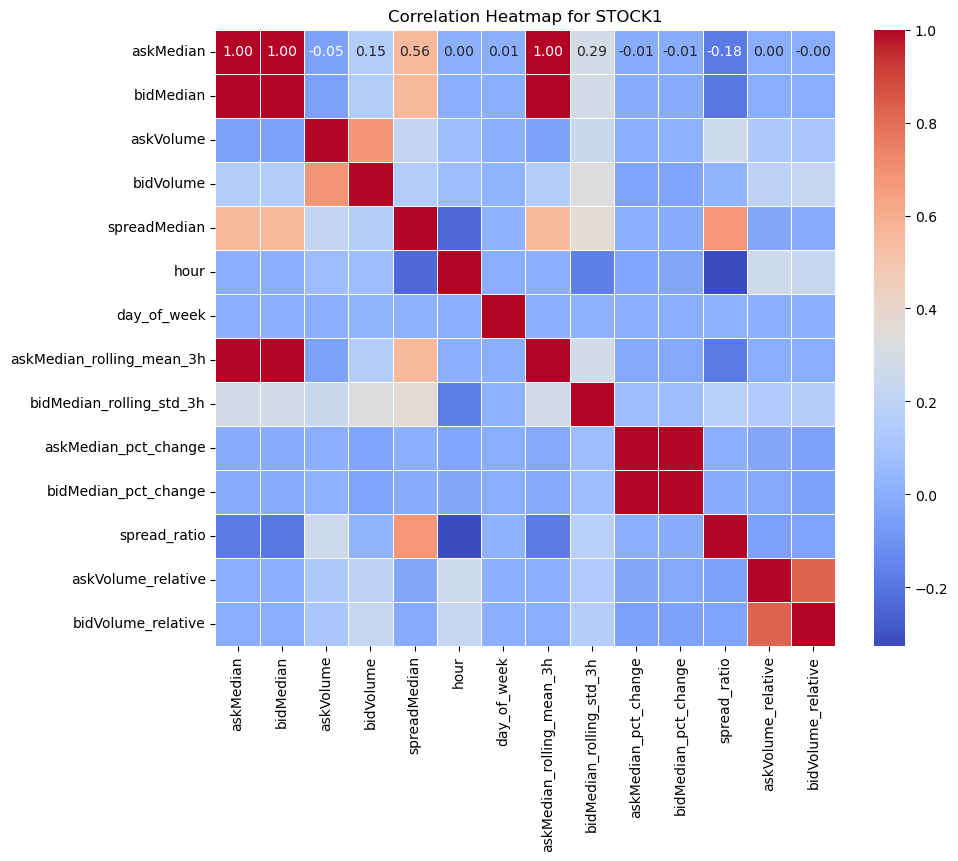

In [ ]:

df_stock = stock_dfs['STOCK1'].drop(['gmtTime', 'symbol'], axis=1)

correlation_matrix = df_stock.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap for STOCK1')
plt.show()


/var/folders/j3/rpb6q3gs7z120k0jct_4_83m0000gn/T/ipykernel_34565/226750058.py:10: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df['signal'][short_window:] = np.where(df['short_mavg'][short_window:] > df['long_mavg'][short_window:], 1, 0)  #

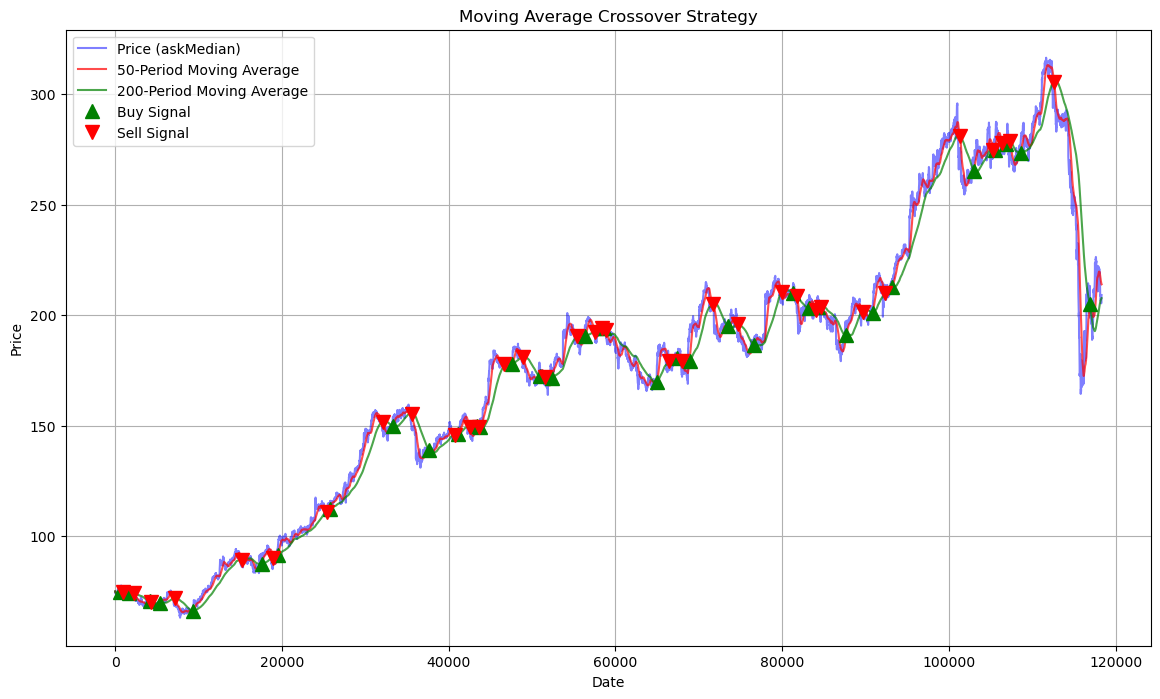

In [62]:
#df = df.iloc[150:250]

short_window = 50
long_window = 200

df['short_mavg'] = df['askMedian'].rolling(window=short_window, min_periods=1).mean()
df['long_mavg'] = df['askMedian'].rolling(window=long_window, min_periods=1).mean()

df['signal'] = 0  # Default: no signal
df['signal'][short_window:] = np.where(df['short_mavg'][short_window:] > df['long_mavg'][short_window:], 1, 0)  # Buy signal
df['position'] = df['signal'].diff()  # Buy (1) or Sell (-1) signal


plt.figure(figsize=(14, 8))
plt.plot(df.index, df['askMedian'], label='Price (askMedian)', color='blue', alpha=0.5)
plt.plot(df.index, df['short_mavg'], label=f'{short_window}-Period Moving Average', color='red', alpha=0.7)
plt.plot(df.index, df['long_mavg'], label=f'{long_window}-Period Moving Average', color='green', alpha=0.7)

plt.plot(df[df['position'] == 1].index, 
         df['short_mavg'][df['position'] == 1], 
         '^', markersize=10, color='g', lw=0, label='Buy Signal')

plt.plot(df[df['position'] == -1].index, 
         df['short_mavg'][df['position'] == -1], 
         'v', markersize=10, color='r', lw=0, label='Sell Signal')

plt.title('Moving Average Crossover Strategy')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)

plt.show()

/var/folders/j3/rpb6q3gs7z120k0jct_4_83m0000gn/T/ipykernel_34565/2229545822.py:8: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df['momentum_signal'][df['rsi'] < 30] = 1  # Buy signal when RSI is below 30 (oversold)
/var/folders/j3/rpb6q3gs7

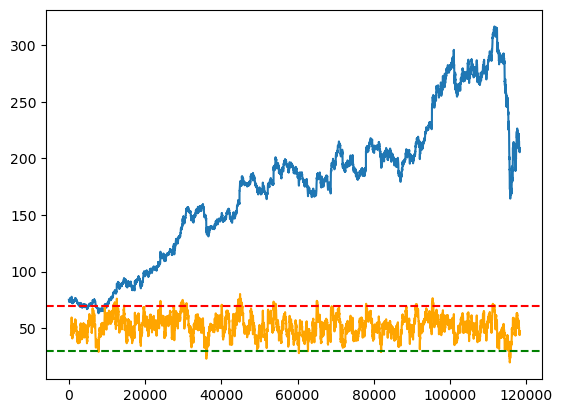

In [ ]:
import talib  

df['rsi'] = talib.RSI(df['askMedian'], timeperiod=50)

df['momentum_signal'] = 0  # Default: no signal
df['momentum_signal'][df['rsi'] < 30] = 1  # Buy signal when RSI is below 30 (oversold)
df['momentum_signal'][df['rsi'] > 70] = -1  # Sell signal when RSI is above 70 (overbought)

plt.plot(df['askMedian'], label='Price')
plt.plot(df['rsi'], label='RSI', color='orange')
plt.axhline(70, color='red', linestyle='--', label="Overbought (Sell Signal)")
plt.axhline(30, color='green', linestyle='--', label="Oversold (Buy Signal)")
